# Assignment 1
#### By Hijun (Jane) Seo | 1001423284

In [1]:
import numpy as np
import pandas as pd
import scipy
!pip uninstall -y scikit-learn
!pip install scikit-learn==0.21.3
from sklearn.impute import SimpleImputer
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

Uninstalling scikit-learn-0.21.3:
  Successfully uninstalled scikit-learn-0.21.3
  Using cached https://files.pythonhosted.org/packages/1f/af/e3c3cd6f61093830059138624dbd26d938d6da1caeec5aeabe772b916069/scikit_learn-0.21.3-cp35-cp35m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.19.0
    Not uninstalling scikit-learn at /usr/local/lib/python3.5/dist-packages, outside environment /resources/common/.virtualenv/python3
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 0. Data importing

In [2]:
Salaries = pd.read_csv("multipleChoiceResponses.csv", low_memory = False) 

# Save a copy of the original data
original = Salaries.copy()

## 1. Data cleaning

### 1.1 Handling missing values within targets

Any rows with missing target variable or where salary is not disclosed is not useful in building the model. Hence, they will be dropped.

In [3]:
Salaries.Q9.unique()

array(['What is your current yearly compensation (approximate $USD)?',
       nan, '10-20,000', '0-10,000',
       'I do not wish to disclose my approximate yearly compensation',
       '20-30,000', '125-150,000', '30-40,000', '50-60,000',
       '100-125,000', '90-100,000', '70-80,000', '80-90,000', '60-70,000',
       '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

### Drop rows missing target variable

In [4]:
Salaries.dropna(subset=['Q9'],inplace=True) 

### Remove rows where salary is not disclosed

In [5]:
Salaries = Salaries[Salaries['Q9']!= "I do not wish to disclose my approximate yearly compensation"]

# Save a copy of the cleaned data
original_cleaned = Salaries.copy()

### 1.2 Dropping irrelevant features

I will drop the first column (Time from Start to Finish (seconds)), which is not a question and does not convey any information about the respondents.

In [6]:
Salaries = Salaries.drop('Time from Start to Finish (seconds)', axis=1)

### 1.3 Handling missing values within features

### Missing values for multiple-choice questions

For some of the survey questions that were multiple-choice, if a certain answer was not selected it was set as NaN. However, this is not a missing value. In order for these NaN's to be not considered as missing, I will be replace these with a string 'N/A'.
For example, Q6 will not be changed since all the answer choices are within the Q6 column.
However, for Q11, there are 7 parts (8 including 'other text') each for a different answer choice so for Q11 I will be changing all NaNs to 'N/A'.

Changing these NaNs to 'N/A' will not affect the result, but will make it easier to encode. Later, when the data is one-hot encoded, the column pertaining to the 'N/A' answers will be dropped, since it will be the complements of the columns of the corresponding multiple choice answers. 

In [7]:
for col in Salaries.columns:
     if 'Part' in col:
            if 'Selected Choice' in Salaries[col].iloc[0]:
                Salaries[col] = Salaries[col].replace(to_replace=np.NaN, value='N/A')

### Missing text data

For any question with manully entered text, the text entered was not saved within the given file. Thus, all questions with manual text answers cannot be used so they will be dropped.

Dropping these columns will result in loss of information. However, even if the text was available, since all manual text entries most likely differ from person to person, the columns would most likely not correlate well with salary. Thus, dropping these columns will likely lead to more accurate predictions later.

In [8]:
for col in Salaries.columns:
    if 'Text' in str(Salaries[col].iloc[0]):
        Salaries = Salaries.drop(col, axis=1)

### 'Other' columns

Columns pertaining to 'other' answers are not consistent and most likely have lots of variations. Thus, these columns with ultimately not be useful in the prediction of salaries. Hence, these columns will be removed.

In [9]:
for col in Salaries.columns:
     if 'OTHER' in col:
            Salaries = Salaries.drop(col, axis=1)

### Columns with > 10% missing data

Columns with missing values for more than 10% of the data will be dropped. Dropping these columns will result in loss of information. However, even without these features, there are still many other features to make a prediction of the salary with. Furthermore, dropping these features will most likely lead to more accurate predictions since imputation of missing values for more than 10% may create unwanted bias, as mentioned in:

Bennett, D. (2001). How can I deal with missing data in my study?. Australian and New Zealand Journal of Public Health, 25(5), pp.464-469.

Dong, Y. and Peng, C. (2013). Principled missing data methods for researchers. SpringerPlus, 2(1).

Madley-Dowd, P., Hughes, R., Tilling, K. and Heron, J. (2019). The proportion of missing data should not be used to guide decisions on multiple imputation. Journal of Clinical Epidemiology, 110, pp.63-73.

In [10]:
dropped_q = []
missingvalue = Salaries.isnull().sum()
for col in missingvalue.index:
    per_miss = missingvalue[col]/Salaries.shape[0] * 100
    if per_miss > 10:
        dropped_q.append(Salaries[col][0])
        Salaries = Salaries.drop(col, axis=1)
        print("Dropping", col, "with", per_miss, "percent missing vals.")

Dropping Q12_MULTIPLE_CHOICE with 10.18794556059624 percent missing vals.
Dropping Q17 with 28.133506156837328 percent missing vals.
Dropping Q18 with 11.808165910563837 percent missing vals.
Dropping Q20 with 37.38820479585224 percent missing vals.
Dropping Q22 with 40.4601425793908 percent missing vals.
Dropping Q23 with 12.754374594944911 percent missing vals.
Dropping Q24 with 12.88399222294232 percent missing vals.
Dropping Q25 with 13.052495139338948 percent missing vals.
Dropping Q26 with 13.110823071937784 percent missing vals.
Dropping Q32 with 33.21451717433571 percent missing vals.
Dropping Q34_Part_1 with 23.74594944912508 percent missing vals.
Dropping Q34_Part_2 with 23.74594944912508 percent missing vals.
Dropping Q34_Part_3 with 23.74594944912508 percent missing vals.
Dropping Q34_Part_4 with 23.74594944912508 percent missing vals.
Dropping Q34_Part_5 with 23.74594944912508 percent missing vals.
Dropping Q34_Part_6 with 23.74594944912508 percent missing vals.
Dropping Q

After reviewing the dropped features, Q12, Q17, Q18, Q20, Q22, Q32, Q34, Q35 and Q37 seem to have had > 10% missing values since there was a section for 'other text'. Although this may mean that with the corresponding 'other text' column, there would have been < 10% missing values, since the 'other text' column was not saved as text within this file, the question was taken out.

Some questions may not have been even presented to the respondent since the Kaggle website mentions under Survey Methodology that "not every question was shown to every respondent". This may be the case for Q23, Q24, Q25, Q26, Q39, Q40, Q41, Q43, Q44, Q45, Q46, and Q48. Another reason for the missing values may be because the respondent didn't understand the question, didn't know how to best answer it, or thought it took much to time to answer the question so skipped it.

### Columns with < 10% missing data

In [11]:
missingvalue = Salaries.isnull().sum()
for col in missingvalue.index:
    per_miss = missingvalue[col]/Salaries.shape[0] * 100
    if per_miss > 0:
        print(col, per_miss, missingvalue[col])

Q5 0.8749189889825016 135
Q8 0.49254698639014904 76
Q10 1.8924173687621517 292


#### Q5 - 'Which best describes your undergraduate major?'
There are 135 NaN values. This is because all the respondents have no formal education past high school, as shown by the corresponding Q4 columns.

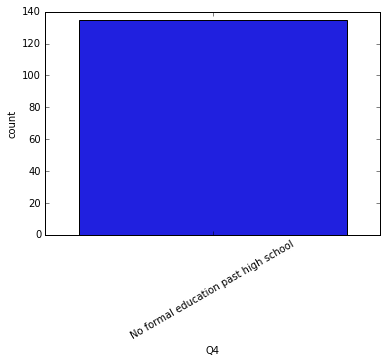

In [12]:
q5_null = Salaries[Salaries['Q5'].isnull()]
ax = sns.countplot(x='Q4', data=q5_null)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

Thus, for these NaN values, I will be creating a new category 'N/A' to replace these NaN values.
Changing these NaNs to 'N/A' will not affect the result as later when the data is one-hot encoded, the column pertaining to the 'N/A' answer will be dropped sinec it will be the complement of the rest of the columns pertaining to the answers of this questions.

In [13]:
Salaries['Q5'] = Salaries['Q5'].replace(to_replace = np.NaN, value = 'N/A')

#### Q8 - 'How many years of experience do you have in your current role?'
There are 76 NaN values. Most of the respondents with NaN values are students, which can explain why they didn't answer the question.

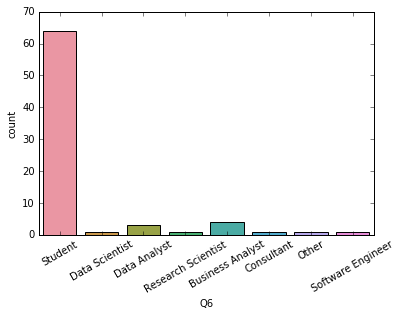

In [14]:
q8_null = Salaries[Salaries['Q8'].isnull()]
ax = sns.countplot(x='Q6', data=q8_null)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [15]:
Salaries.Q8.value_counts().head()

0-1     3879
1-2     2826
5-10    1973
2-3     1965
3-4     1308
Name: Q8, dtype: int64

Thus, for the NaNs in the 'Q8' column, I will be replacing them with '0-1' since most of the corresponding respondents will not have had any experience. '0-1' is also the mode of the column so the mode of the dataset will not change.

In [16]:
Salaries['Q8'] = Salaries['Q8'].replace(to_replace = np.NaN, value = Salaries.Q8.value_counts().index[0])

#### Q10 - 'Does your current employer incorporate machine learning methods into their business?'
There are 292 NaN values.
The respondents coresponding to these NaN values are for the most part students, but there are also people working fields such as Computers/Technology and Acadmeic/Education that have left this field blank.

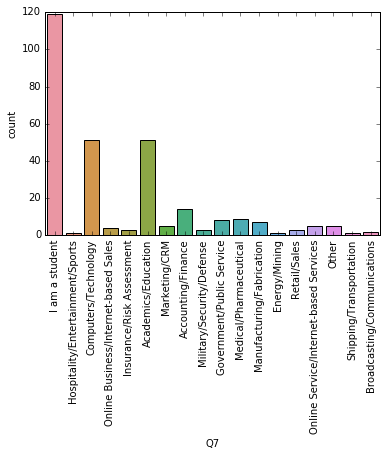

In [17]:
q10_null = Salaries[Salaries['Q10'].isnull()]
ax = sns.countplot(x='Q7', data=q10_null)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

The null values submitted by students will be changed to a new category 'N/A'. This will not affect the result as later when the data is one-hot encoded, the column pertaining to the 'N/A' answer will be dropped.

In [18]:
Salaries['Q10'] = Salaries[Salaries['Q7'] == 'I am a student'].Q10.replace(to_replace = np.NaN, value = 'N/A')

In [19]:
Salaries.Q10.value_counts().head()

I do not know                                                                                779
No (we do not use ML methods)                                                                428
We are exploring ML methods (and may one day put a model into production)                    408
We recently started using ML methods (i.e., models in production for less than 2 years)      228
We use ML methods for generating insights (but do not put working models into production)    166
Name: Q10, dtype: int64

The respondents with specified positions who had submitted a null value will be dropped since imputing the mode ('We are exploring ML methods (and may one day put a model into production') may lead to less accurate predictions since this answer for the respondents is most likely not correct.

In [20]:
Salaries.dropna(subset=['Q10'],inplace=True) 

### Final Check

In [21]:
missingvalue = Salaries.isnull().sum()
print("There are", missingvalue.sum(), "missing values.")

There are 0 missing values.


Now there are no missing values!

In [22]:
print("After cleaning data, the data is of size:", Salaries.shape)

After cleaning data, the data is of size: (2248, 311)


### 1.4 Data encoding

The features will be one hot encoded so that the features are binary values, which will aid in the classification of data through logistic regression.

The target column (Q9) pertaining to the salaries of each respondents will be  encoded by turning the columns of categorical data into numerical data with each category represented by the mean amount of salary. In other words, the salary category of 0-10,000 will be set as 5,000 and 10-20,000 to 15,000. This is much like ordinal encoding since it will preserve the order of the data (5000 is less than 15,000), but also the spacing between the data. From 0 to 100,000, the bins increment consistently by 10,000, but from 100,000, the increment changes to 25,000, then to 50,000, and finally to 100,000. Setting the target columns as the mean salary will preserve this change in increments.

#### One-hot encoding of features

In [23]:
Salaries_copy = Salaries.copy()
Salaries_copy = Salaries_copy.drop('Q9', axis=1)
onehotencoded = pd.get_dummies(Salaries_copy)

All columns with 'N/A' will be dropped since these columns are the complement of other columns and does not provide any more information. (Refer to Section 1.3)

In [24]:
for col in onehotencoded.columns:
    if 'N/A' in col:
        onehotencoded = onehotencoded.drop(col, axis=1)

#### Encoding of targets with mean values

In [25]:
target_encode = {'0-10,000': 5000, '10-20,000': 15000, '20-30,000': 25000, '30-40,000': 35000, 
       '40-50,000': 45000, '50-60,000': 55000, '60-70,000': 65000, '70-80,000': 75000, 
       '80-90,000': 85000, '90-100,000': 95000, '100-125,000': 112500, 
       '125-150,000': 137500, '150-200,000': 175000, '200-250,000': 225000, 
       '250-300,000': 275000, '300-400,000': 350000, '400-500,000': 450000, 
       '500,000+':500000}

encoded = pd.concat([onehotencoded, Salaries['Q9']], axis=1)
encoded['Q9'] = encoded['Q9'].apply(lambda x: target_encode[x])

In [26]:
print("After encoding data, the data is of size:", encoded.shape)

After encoding data, the data is of size: (2248, 426)


## 2. Exploratory data analysis

### Changing salaries data from categorical to numeric
Visualization of data will be easier with numeric targets, but categorical features. Thus, the targets will be encoded, but the features will be copied from the original categorical data.

In [27]:
int_Salaries = Salaries.copy()
int_Salaries['Q9'] = int_Salaries['Q9'].apply(lambda x: target_encode[x])

In [28]:
Salaries['Q9'].value_counts()

0-10,000       1788
10-20,000       198
20-30,000       105
30-40,000        57
40-50,000        21
50-60,000        13
70-80,000        12
80-90,000        10
100-125,000       8
90-100,000        8
60-70,000         7
125-150,000       6
500,000+          6
150-200,000       4
300-400,000       3
200-250,000       2
Name: Q9, dtype: int64

In [29]:
Salaries['Q3'].value_counts().head()

India                       536
United States of America    410
China                       279
Other                        72
Brazil                       67
Name: Q3, dtype: int64

One thing to note before visualizing the data is that the majority of the respondents have less than 50K USD salaries, even though the average income of an American is more than 60K USD. This may be because the majority of the respondents are from India or China where the average income is much less (~15K, sourced from Google). Furthermore, the reason they are using Kaggle may be to find a better job by learning more skills, which may be why the majority of salaries is less than 50K USD.

One feature that most likely shows a trend with salary data is the age. Respondents who are younger are more likely to be students or just starting to work, so they probably have low income. On the other hand, older respondents who have worked for longer and have gained more experience probably have a higher income.

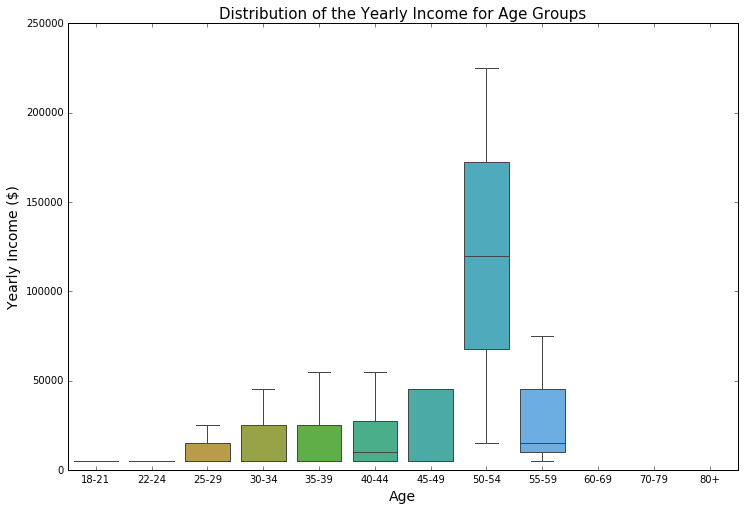

In [30]:
order = ['18-21', '22-24', '25-29', '30-34','35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70-79', '80+']

plt.figure(figsize=(12,8))
boxplot = sns.boxplot(x='Q2', y='Q9', data=int_Salaries, order=order, showfliers=False)
ax = boxplot.axes
ax.set_ylim([0, 250000])
plt.ylabel("Yearly Income ($)", fontsize=14)
plt.xlabel("Age", fontsize=14)
plt.title("Distribution of the Yearly Income for Age Groups", fontsize=15)
plt.show()

Plotting income vs age shows, as I expected, higher income for increasing age. However, there a large variance in income from age 50-54 following a  decrease in income from 55+. This is expected since most people are starting to retire or starting and by the time most people are 60, most of them would not be working.

This trend can help predict salaries since based on the age, we could predict the income level. Young and old respondents (ages 18-24 and 60+) can be classified as having the lowest salary while middle-aged respondents (30s or 40s) should have higher income.

Another feature that may show a trend with income is the degree the respondents have attained. It is likely that respondents with higher degrees (e.g. Doctoral) earn more than people without any college degree due to more skillsets and experience.

In [31]:
int_Salaries['Q4'] = int_Salaries['Q4'].replace(to_replace='Some college/university study without earning a bachelor’s degree', value='Some college/university')

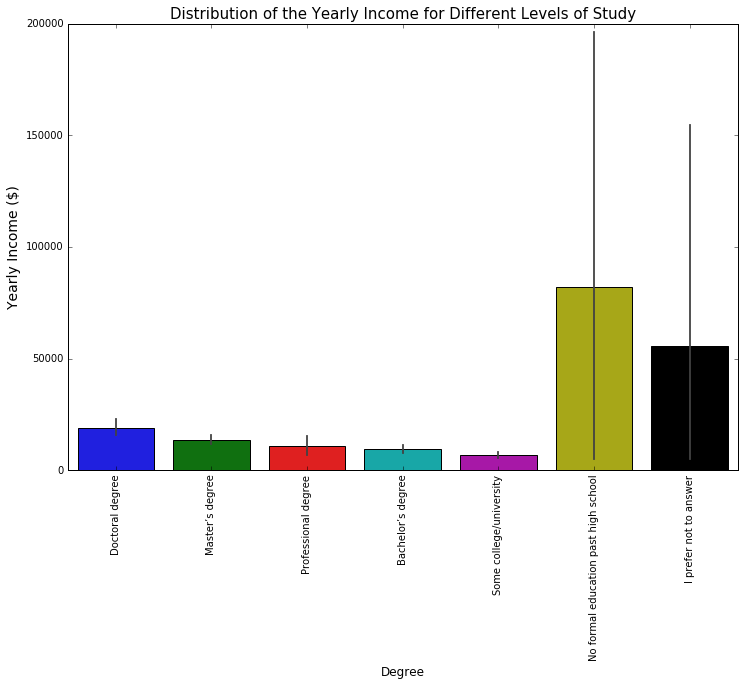

In [32]:
order = ['Doctoral degree', 'Master’s degree', 'Professional degree', 'Bachelor’s degree',  'Some college/university',
        'No formal education past high school', 'I prefer not to answer']
plt.figure(figsize=(12,8))
sns.barplot(x='Q4', y='Q9', data=int_Salaries, order=order)
plt.xticks(rotation=90)
plt.ylabel("Yearly Income ($)", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.title("Distribution of the Yearly Income for Different Levels of Study", fontsize=15)
plt.show()

The respondents who had answered that they had no formal education past high school or that they did not prefer to answer has high variance in the income that they are receiving. This can be because there are anomolies within these groups. For example, they may have created a very successful startup right out of high school, or they may have been lying about their income.

Excluding these groups with high number of anomalies, I will be just looking at people who have attained doctorate, master's, bachelor's, or some college/university.

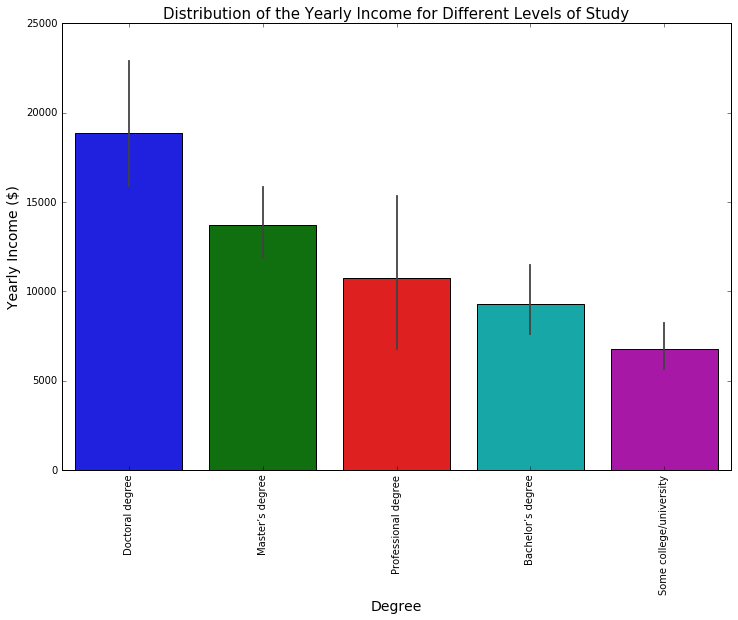

In [33]:
order = ['Doctoral degree', 'Master’s degree', 'Professional degree', 'Bachelor’s degree',  'Some college/university']
plt.figure(figsize=(12,8))
sns.barplot(x='Q4', y='Q9', data=int_Salaries, order=order)
plt.xticks(rotation=90)
plt.ylabel("Yearly Income ($)", fontsize=14)
plt.xlabel("Degree", fontsize=14)
plt.title("Distribution of the Yearly Income for Different Levels of Study", fontsize=15)
plt.show()

This graph shows a clear trend. People who have attained a higher degree earn more. Thus, based on the degree, we are able to predict the range of income that is most likely.

Where the respondents work can also be an important factor in deciding the income. A country with higher GDP or more expensive living costs is more likely to provide more income than countries with lower GDP or cheaper living expenses. Smaller countries will be grouped by continent to see a more general outlook but big countries like USA, India, and China will be grouped separately.

In [34]:
country_dic = {'Morocco': 'Africa',
             'Tunisia': 'Africa',
             'Austria': 'Europe',
             'Hong Kong (S.A.R.)': 'Asia',
             'Republic of Korea': 'Asia',
             'Thailand': 'Asia',
             'Czech Republic': 'Europe',
             'Philippines': 'Asia',
             'Romania': 'Europe',
             'Kenya': 'Africa',
             'Finland': 'Europe',
             'Norway': 'Europe',
             'Peru': 'South America',
             'Iran, Islamic Republic of...': 'Middle East',
             'Bangladesh': 'Asia',
             'New Zealand': 'Oceania',
             'Egypt': 'Africa',
             'Chile': 'South America',
             'Belarus': 'Europe',
             'Hungary': 'Europe',
             'Ireland': 'Europe',
             'Belgium': 'Europe',
             'Malaysia': 'Asia',
             'Denmark': 'Europe',
             'Greece': 'Europe',
             'Pakistan': 'Asia',
             'Viet Nam': 'Asia',
             'Argentina': 'South America',
             'Colombia': 'South America',
             'Indonesia': 'Oceania',
             'Portugal': 'Europe',
             'South Africa': 'Africa',
             'South Korea': 'Asia',
             'Switzerland': 'Europe',
             'Sweden': 'Europe',
             'Israel': 'Middle East',
             'Nigeria': 'Africa',
             'Singapore': 'Asia',
             'I do not wish to disclose my location': 'N/A',
             'Mexico': 'North America',
             'Ukraine': 'Europe',
             'Netherlands': 'Europe',
             'Turkey': 'Asia',
             'Poland': 'Europe',
             'Australia': 'Oceania',
             'Italy': 'Europe',
             'Spain': 'Europe',
             'Japan': 'Asia',
             'France': 'Europe',
             'Canada': 'North America', 
             'United Kingdom of Great Britain and Northern Ireland': 'UK',
             'Germany': 'Europe',
             'Brazil': 'South America',
             'Russia': 'Russia',
             'Other': 'Other',
             'China': 'China',
             'India': 'India',
             'United States of America': 'USA'}

In [35]:
int_Salaries['Q3'] = int_Salaries['Q3'].apply(lambda x: country_dic[x])

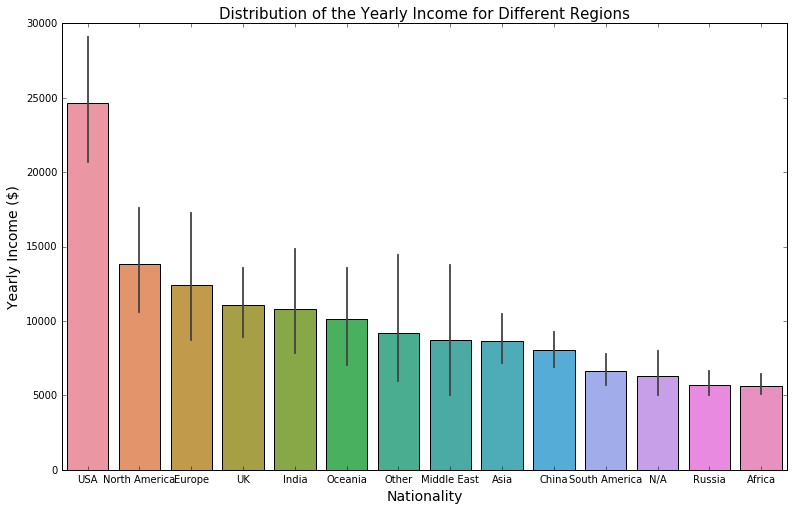

In [36]:
plt.figure(figsize=(13,8))
sns.barplot(x='Q3', y='Q9', data=int_Salaries, order=int_Salaries.groupby('Q3').Q9.mean().sort_values(ascending=False).index)
plt.ylabel("Yearly Income ($)", fontsize=14)
plt.xlabel("Nationality", fontsize=14)
plt.title("Distribution of the Yearly Income for Different Regions", fontsize=15)
plt.show()

The graph shows a relationship between income and nationality. Respondents who working USA, North America, and Europe have on average more income than those working in South America, Russia, and Africa. Thus, using nationality data can help predict the range of salary that the respondent is expected to receive.

### Order of feature importance

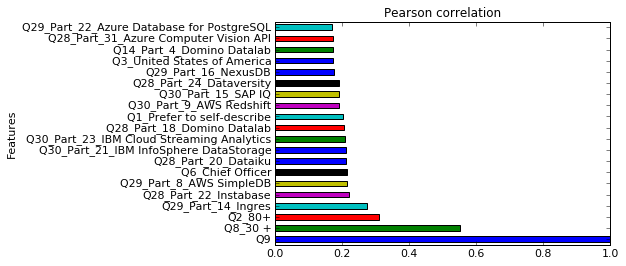

In [37]:
pearsoncorr = encoded.corr().apply(lambda x: abs(x))
plt.figure()
ax = (pearsoncorr.sort_values('Q9', ascending=False)['Q9'][:20].plot(kind="barh",title="Pearson correlation",fontsize=11))
ax.set_ylabel('Features',fontsize=11)

Using Pearson correlation, we are able to see that years of experience and age correlate with salary the most. This is expected since we saw that there was a trend in income with age, and with age comes experience. We also see a high correlation between salary and nationality, as expected from the trend that I had plotted. Other questions that correlated with the salaries well are Q28, Q29, and Q30, which are different products that respondents have used. This may show a good correlation with income since the respondents who use professional products made by IBM and AWS usually are more experienced, can afford the software, or are employed by these companies and may have higher salaries.

## 3. Feature selection

Feature engineering useful in machine learning because it can improve the algorithm's predictive power and allow for simple models to be fit on complex data. For example, nonlinear data can be transformed into linear data through feature engineering and can allow for simple models such as linear regression to easily and accurately make predictions.

#### Dividing dataset into X_train, y_train, X_test, and y_test

In [38]:
all_X = encoded.drop('Q9', axis=1)
all_y = encoded['Q9']
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=1)

#### Scaling/Normalizing the data

I will be scaling the features to a range which is centered around zero so that the variance of the features are in the same range. This is so that if a feature’s variance is larger than the variance of other features, that particular feature won't dominate other features in the dataset.

In [39]:
scaler = StandardScaler()

X_train_scalar = scaler.fit_transform(X_train)
X_test_scalar = scaler.transform(X_test)

#### Using Lasso for feature selection

Lasso is a regularization method that is used to 'push' weights of features towards zero if they are small enough. Features that have smaller weights have little impact on the classification decision. Thus, these will be set to zero (i.e. these features will be eliminated).

In [40]:
clf = LassoCV(cv=5)

sfm_1 = SelectFromModel(clf, threshold=1)
sfm_1.fit(X_train_scalar, y_train)

sfm_5 = SelectFromModel(clf, threshold=5)
sfm_5.fit(X_train_scalar, y_train)

sfm_10 = SelectFromModel(clf, threshold=10)
sfm_10.fit(X_train_scalar, y_train)

sfm_50 = SelectFromModel(clf, threshold=50)
sfm_50.fit(X_train_scalar, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=None, normalize=False,
                                  positive=False, precompute='auto',
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=50)

In [41]:
def get_sel_feat(sfm):
    selected_feat = []
    for val in range(len(sfm.get_support())):
        if sfm.get_support()[val] == True:
            print(X_train.columns[val])
            selected_feat.append(X_train.columns[val])
    return selected_feat

In [42]:
%%capture
feat1 = get_sel_feat(sfm_1)
feat5 = get_sel_feat(sfm_5)
feat10 = get_sel_feat(sfm_10)
feat50 = get_sel_feat(sfm_50)

The features are selected based on the threshold applied. These features have an importance (or coefficients) of greater than 1, 5, 10, and 50. Later, the features selected with each of these thresholds will be compared in the model implementation section and the best model will be selected.

In [43]:
print(len(feat1))
print(len(feat5))
print(len(feat10))
print(len(feat50))

57
56
55
45


Since the selected number features isn't very large, I will not reduce the dimensionality using PCA. However, the code below shows that I can reduce the dimensions to 10 features that explains ~60% of the selected data's variance.

PCA (Principle Component Analysis) is a feature engineering technique that projects the data into a lower dimensional space while keeping most of the information.

In [44]:
PCA_model = PCA(n_components=10).fit(X_train[feat1])
X_train_PCA = PCA_model.transform(X_train[feat1])
X_test_PCA = PCA_model.transform(X_test[feat1])
print("Explained Variance: ", PCA_model.explained_variance_ratio_.sum())

Explained Variance:  0.6084492570223776


## 4. Implementing Model

### Implementing logistic regression on all features

This is the base accuracy that logistic regression is able to attain with no feature selection.

In [45]:
log_model = LogisticRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

In [46]:
# scores = cross_val_score(log_model, X_train, y_train, cv=crossvalidation)
# print(scores)
# print("Average accuracy:", scores.mean(),"\nVariance:", scores.std() * 2)

K-fold accuracies: [0.74050633 0.81012658 0.78481013 0.76433121 0.72611465 0.78980892 0.75159236 0.74522293 0.80254777 0.82165605]

Average accuracy: 0.7736716923325002 

Variance: 0.06195303929064368

### Using features from Lasso

In [47]:
# scores1 = cross_val_score(log_model, X_train[feat1], y_train, cv=crossvalidation)
# print(scores1)
# print("Average accuracy:", scores1.mean(),"\nVariance:", scores1.std() * 2)

K-fold accuracies: [0.79113924 0.82278481 0.79746835 0.78343949 0.7388535  0.8343949 0.78343949 0.75796178 0.82802548 0.85350318]

Average accuracy: 0.7991010239458196 

Variance: 0.06776908612867882

In [48]:
# scores5 = cross_val_score(log_model, X_train[feat5], y_train, cv=crossvalidation)
# print(scores5)
# print("Average accuracy:", scores5.mean(),"\nVariance:", scores5.std() * 2)

K-fold accuracies: [0.79746835 0.82278481 0.79113924 0.78343949 0.74522293 0.82802548 0.78343949 0.76433121 0.82802548 0.85350318]
 
Average accuracy: 0.7997379666209788 

Variance: 0.06279528563880767

In [49]:
# scores10 = cross_val_score(log_model, X_train[feat10], y_train, cv=crossvalidation)
# print(scores10)
# print("Average accuracy:", scores10.mean(),"\nVariance:", scores10.std() * 2)

K-fold accuracies: [0.79746835 0.82278481 0.78481013 0.78343949 0.73248408 0.82165605 0.78343949 0.76433121 0.82165605 0.84076433]
 
Average accuracy: 0.7952833991776183 

Variance: 0.06168529504817857

In [50]:
# scores50 = cross_val_score(log_model, X_train[feat50], y_train, cv=crossvalidation)
# print(scores50)
# print("Average accuracy:", scores50.mean(),"\nVariance:", scores50.std() * 2)

K-fold accuracies: [0.77848101 0.82278481 0.81012658 0.79617834 0.73248408 0.82802548 0.78980892 0.76433121 0.82165605 0.84713376]
 
Average accuracy: 0.7991010239458196 

Variance: 0.06481299032253841

The accuracy across the folds changes in no particular manner (doesn't continuously increase or decrease).
This is because during cross-validation 9 subsets are the training data are used to train and 1 subset to validate, and the accuracy depends on if the data of the 9 subsets led to overfitting or underfitting. High accuracies were a result of good bias-variance tradeoff (only little overfitting or underfitting).

The best model with the highest accuracy was Lasso with a threshold of 5. The accuracies of Lasso with threshold of less than 5 were lower most likely since with more features, there is overfitting (or high variance) which is a result of the model capturing nuances of the training data that is not present in the testing data. On the other hand, accuracies of Lasso with threshold of greater than 5 were lower most likely since with less features, there is underfitting (or high bias) which is a result of the model not being able to capture the noise of the data well enough to generalize to new data well.

## 5. Model tuning

To tune the hyperparameters (L1 and L2) and different regularization values (C), I will do a grid search.
Although Lasso has already been applied, it could be applied further to select even fewer features.

I will be using the F1-score to evaluate the best model. The F1-score takes into consideration both the precision and recall, which is ideal for predicting salary data since neither false negatives nor false positives is worse than the other. Since there are more data points for one salary bin (i.e. 0-10,000) than other bins, I will be using weighted F1 scoring for grid search so that each bin's contribution to the average is weighted by the relative number of examples available for it.

Let's first see the F1-score without any tuning.

In [51]:
clf = LogisticRegression()
clf.fit(X_train[feat5], y_train)
y_pred = clf.predict(X_train[feat5])
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

        5000       0.84      0.99      0.91      1249
       15000       0.31      0.09      0.14       141
       25000       0.51      0.26      0.34        77
       35000       0.43      0.08      0.13        38
       45000       0.00      0.00      0.00        15
       55000       1.00      0.18      0.31        11
       65000       0.00      0.00      0.00         4
       75000       1.00      0.30      0.46        10
       85000       0.00      0.00      0.00         6
       95000       0.00      0.00      0.00         4
      112500       0.00      0.00      0.00         4
      137500       0.00      0.00      0.00         4
      175000       1.00      1.00      1.00         1
      225000       0.00      0.00      0.00         1
      350000       0.00      0.00      0.00         2
      500000       1.00      0.33      0.50         6

    accuracy                           0.81      1573
   macro avg       0.38   

In [52]:
C = np.linspace(1, 100, 100)
# clf = LogisticRegression()
# grid_values = {'penalty': ['l1', 'l2'],'C':C}
# grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'f1_weighted', cv = 10, verbose=True, n_jobs=-1)
# grid_clf_acc.fit(X_train[feat5], y_train)
# y_pred_acc = grid_clf_acc.predict(X_train[feat5])
# print(grid_clf_acc.best_params_)

From grid search, the best parameters are C=96 with L2 penalty.

In [53]:
best_model = LogisticRegression(penalty='l2', C=96)
best_model.fit(X_train[feat5], y_train)
y_pred_acc = best_model.predict(X_train[feat5])

In [54]:
predicted_prob = pd.DataFrame(best_model.predict_proba(X_train[feat5]), columns=np.sort(y_train.unique()))
predicted_prob.head()

,5000,15000,25000,35000,45000,55000,65000,75000,85000,95000,112500,137500,175000,225000,350000,500000
0,0.663428,0.178644,0.113695,0.033410,0.010307,3.057623e-08,1.905147e-11,2.553862e-04,2.534621e-09,1.703736e-05,1.074394e-07,3.052153e-08,0.000159,0.000026,5.275538e-05,4.545012e-06
1,0.831539,0.121137,0.006627,0.028847,0.008294,3.512585e-03,5.921122e-08,7.216395e-06,7.303606e-08,1.464720e-07,1.108516e-07,2.227293e-11,0.000009,0.000027,1.721149e-10,4.798393e-08
2,0.871990,0.067964,0.026653,0.003686,0.000034,2.952511e-02,8.939142e-08,2.038879e-11,4.006851e-06,1.403847e-05,1.912158e-06,5.959458e-05,0.000053,0.000015,4.241585e-09,2.303960e-07
3,0.010854,0.345690,0.011732,0.007491,0.000934,2.016750e-03,8.848416e-04,1.588940e-05,1.391675e-02,6.056324e-01,4.390682e-05,5.301195e-05,0.000029,0.000046,1.111871e-08,6.612309e-04
4,0.948041,0.036531,0.012947,0.002265,0.000036,1.559755e-04,2.659202e-10,3.872945e-07,4.609244e-09,2.884716e-07,1.339346e-07,1.473481e-13,0.000003,0.000013,9.496107e-07,5.679081e-06


predicted_prob is the output of the prediction that represents the probabilities of belonging to each of the salary ranges.

In [55]:
print(classification_report(y_train,y_pred_acc))

              precision    recall  f1-score   support

        5000       0.85      0.99      0.92      1249
       15000       0.45      0.14      0.22       141
       25000       0.56      0.29      0.38        77
       35000       0.64      0.18      0.29        38
       45000       1.00      0.13      0.24        15
       55000       1.00      0.27      0.43        11
       65000       1.00      1.00      1.00         4
       75000       1.00      0.60      0.75        10
       85000       1.00      0.67      0.80         6
       95000       1.00      0.25      0.40         4
      112500       1.00      1.00      1.00         4
      137500       1.00      0.75      0.86         4
      175000       1.00      1.00      1.00         1
      225000       1.00      1.00      1.00         1
      350000       1.00      0.50      0.67         2
      500000       1.00      0.83      0.91         6

    accuracy                           0.84      1573
   macro avg       0.91   

Grid search has successfully helped find better hyperparameteres that ultimately increased the F1-score overall when compared to the F1-score before tuning.

In [56]:
cm = confusion_matrix(y_train,y_pred_acc,labels=np.sort(y_train.unique()))

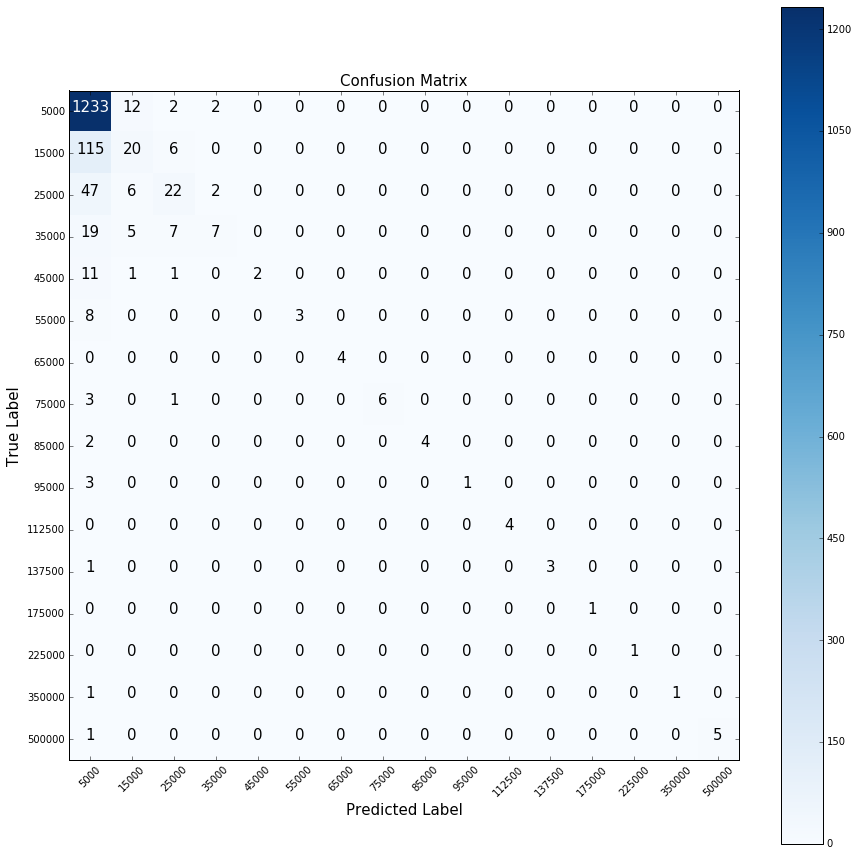

In [57]:
plt.figure(figsize=(15,15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y_train.unique()))
plt.xticks(tick_marks, np.sort(y_train.unique()), rotation=45, fontsize=10)
plt.yticks(tick_marks, np.sort(y_train.unique()), fontsize=10)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 200:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

The confusion matrix shows that for the most part the model is predicting accurately, but most of the error lies in predicting 5000 (the lowest salary range). This is most likely because the majority of the target salaries is 5000 so 5000 is the most likely prediction the model makes, which contributes to the most error.

### 6. Testing

In [58]:
best_model = LogisticRegression(penalty='l2', C=96)
best_model.fit(X_train[feat5], y_train)

LogisticRegression(C=96, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
predicted_prob = pd.DataFrame(best_model.predict_proba(X_test[feat5]))

In [60]:
predicted_prob.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.958852,0.027782,0.007412,0.001191,0.000671,5.744016e-06,8.559985e-07,3.836059e-05,0.000002,1.217029e-03,1.631735e-06,2.223040e-04,0.000036,4.458621e-05,2.511497e-05,2.498800e-03
1,0.834340,0.164190,0.000951,0.000017,0.000444,1.028987e-05,3.113322e-05,4.808128e-11,0.000004,7.346543e-11,1.472030e-07,2.566923e-09,0.000003,8.925194e-06,3.079609e-12,2.215961e-09
2,0.976077,0.016218,0.002506,0.000002,0.001355,4.069306e-07,6.119408e-08,4.684774e-08,0.000065,3.390009e-04,1.545564e-10,8.560752e-07,0.000001,4.923946e-07,4.530719e-07,3.435967e-03
3,0.873084,0.072244,0.023845,0.009539,0.007520,8.663156e-03,4.248195e-08,2.098446e-06,0.000072,4.814008e-03,9.125111e-07,4.276823e-05,0.000072,8.275566e-05,3.695540e-08,1.617170e-05
4,0.941650,0.054505,0.000359,0.000355,0.002921,7.424395e-09,2.287826e-08,3.289600e-05,0.000009,4.361846e-06,1.128792e-08,1.230848e-04,0.000015,4.581011e-06,1.330777e-06,2.027324e-05


In [61]:
print("Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, best_model.predict(X_train[feat5])))
print("Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, best_model.predict(X_test[feat5])))

Logistic regression Train Accuracy ::  0.8372536554354736
Logistic regression Test Accuracy ::  0.7955555555555556


Since the train accuracy is greater than the test accuracy, the model is overfitting.

In [62]:
training_acc = []
test_acc = []
for parameter in C:
    model = LogisticRegression(penalty='l2', C=parameter)
    model.fit(X_train[feat5], y_train)
    training_acc.append(metrics.accuracy_score(y_train, model.predict(X_train[feat5])))
    test_acc.append(metrics.accuracy_score(y_test, model.predict(X_test[feat5])))

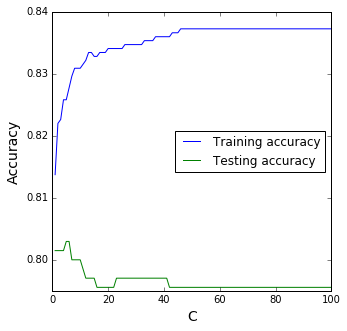

In [63]:
fig=plt.figure(figsize=(5,5))
fig.show()
ax=fig.add_subplot(111)

ax.plot(C,training_acc,c='b',label='Training accuracy')
ax.plot(C,test_acc,c='g', label='Testing accuracy')
plt.xlabel('C', fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend(loc=7)
plt.draw()

Plotting for testing and training accuracies over different C values, you can see that both the testing and training accuracy saturates for large values of C. You can also see that for small values of C, training and testing accuracies are similar, meaning that there is minimal bias-variance tradeoff so the model doesn't underfit or overfit too much. This would have given the best testing accuracy since there is lower generalization error. Larger values of C for L2 regularization lead to higher training accuracy since the model overfits. Overfitting leads to lower testing accuracies since the model cannot generalize and captures noise in the training data that is not present in the testing data.